In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
from sklift.metrics import qini_curve, qini_auc_score, uplift_curve
from sklift.viz import plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
columns_x = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.675390,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.385550,-0.768253,-1.823462,-1.141620,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.403630,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.317210,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.403630,1.901629,1.395651,-0.811559,...,0.023680,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.640620,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.236080,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541000,-0.005574,0.373186,-0.428608,0.252528,-0.955742,-0.205677,-0.683525
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,-0.702715,-0.705604
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.554080,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.444100,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


# Is this breaking Qini curve?

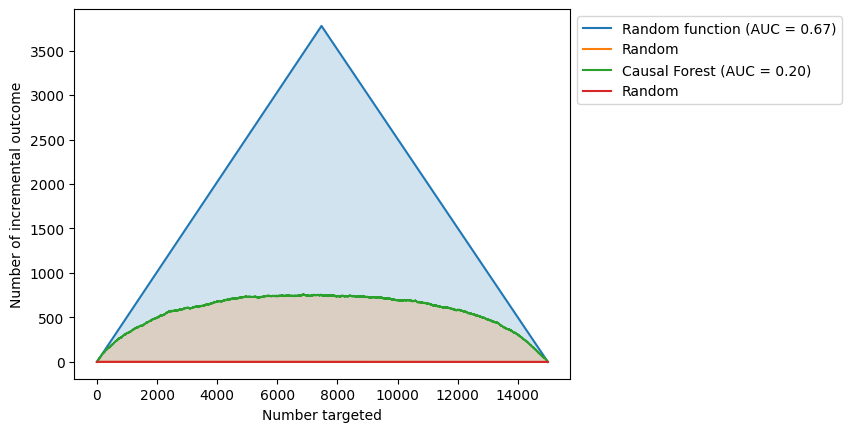

In [3]:
import simulate_data

e = lambda x: 0.5
d = 10
weights_1 = np.random.uniform(1, 30, d)
weights_2 = np.random.uniform(1, 30, d)
mu_0 = lambda x: 1 if np.dot(x, weights_1) > 0 else 0
mu_1 = lambda x: 1 if np.dot(x, weights_2) > 0 else 0
n_test = 50000

random_data = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))
random_data_train, random_data_test = train_test_split(random_data, test_size=0.3)
random_data_train_x = pd.DataFrame(random_data_train["X"].tolist(), index = random_data_train.index)
random_data_train_x.columns = random_data_train_x.columns.astype(str)
random_data_test_x = pd.DataFrame(random_data_test["X"].tolist(), index = random_data_test.index)
random_data_test_x.columns = random_data_test_x.columns.astype(str)

# random_cate = list(map(lambda x: 1 if x[0] > 0 else 0, random_data_test["X"]))
random_cate = random_data_test["W"].to_list()
# random_cate = list(map(lambda x: 1, random_data_test["W"].to_list()))

forest = CausalForest()
forest.fit(random_data_train_x, random_data_train["W"], random_data_train["Y"])

fig, ax = plt.subplots(1, 1)

plot_qini_curve(y_true=random_data_test["Y"].to_list(), uplift=random_cate, treatment=random_data_test["W"].to_list(), perfect=False, name="Random function", ax=ax)
plot_qini_curve(y_true=random_data_test["Y"].to_list(), uplift=np.concatenate(forest.predict(X=random_data_test_x)).tolist(), treatment=random_data_test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax)

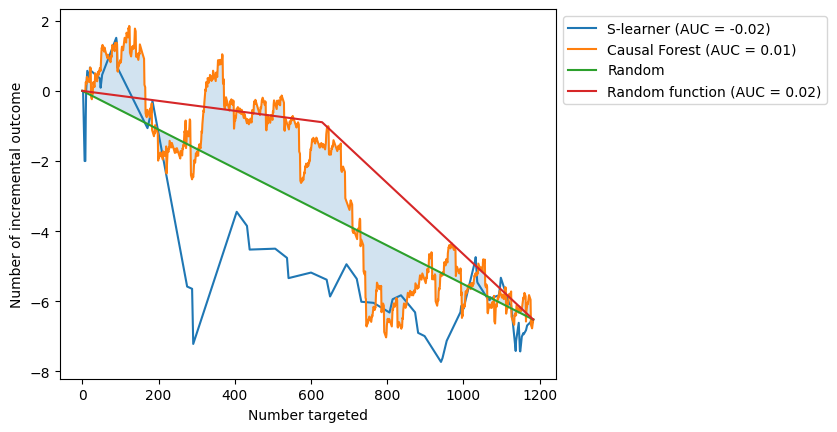

In [9]:
full_data = imp_xs.assign(W=w, Y=y)
train, test = train_test_split(full_data, test_size=0.3)

train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor()
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
causal_forest = CausalForest()
causal_forest.fit(X=train_x, T=train["W"], y=train["Y"])

random_cate = test_x.apply(lambda x: 1 if x["age"] > 0 else 0, axis=1).tolist()

fig, ax = plt.subplots(1, 1)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), treatment=test["W"].to_list(), perfect=False, random=False, name="S-learner", ax=ax)

# plot_qini_curve(y_true=test["Y"].to_list(), uplift=(regr1_t.predict(test_x) - regr0_t.predict(test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, random=False, name="T-learner", ax=ax)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=np.concatenate(causal_forest.predict(X=test_x)).tolist(), treatment=test["W"].to_list(), perfect=False, name="Causal Forest", ax=ax)

plot_qini_curve(y_true=test["Y"].to_list(), uplift=random_cate, treatment=test["W"].to_list(), perfect=False, random=False, name="Random function", ax=ax)

In [6]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

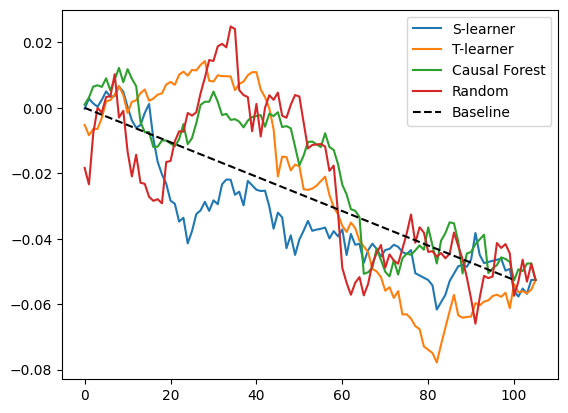

In [10]:
s_learner_cate_test = test.assign(cate=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})))
t_learner_cate_test = test.assign(cate=regr1_t.predict(test_x) - regr0_t.predict(test_x))
causal_forest_cate_test = test.assign(cate=causal_forest.predict(test_x))
test_with_random_cate = test.assign(cate=random_cate)

gain_curve_test_s = cumulative_gain(s_learner_cate_test, "cate", y="Y", t="W")
gain_curve_test_t = cumulative_gain(t_learner_cate_test, "cate", y="Y", t="W")
gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")
gain_curve_random = cumulative_gain(test_with_random_cate, "cate", y="Y", t="W")

plt.plot(gain_curve_test_s, color="C0", label="S-learner")
plt.plot(gain_curve_test_t, color="C1", label="T-learner")
plt.plot(gain_curve_test_c_f, color="C2", label="Causal Forest")
plt.plot(gain_curve_random, color="C3", label="Random")
plt.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
plt.legend()